In [2]:
import pandas as pd
from datasets import Dataset
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TrainingArguments, 
                          Trainer,
                          DataCollatorWithPadding)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from nltk.corpus import stopwords as nltk_stopwords

# Загрузка размеченного датасета

In [ ]:
# 1. Загружаем данные
df = pd.read_csv('geo-reviews-dataset-2023.csv') # Колонки: 'review', 'label'
df_1 = df.loc[df['label'] == 1]
df_2 = df.loc[df['label'] == 2]
df_3 = df.loc[df['label'] == 3]
df_4 = df.loc[df['label'] == 4]
df_5 = df.loc[df['label'] == 5]

df_new = pd.concat([df_1[0:5000], df_2[0:5000], df_3[0:5000], df_4[0:5000], df_5[0:5000]], ignore_index=True)
df_new = df_new.sample(frac=1).reset_index(drop=True) #перемешать
df_new.shape

(25000, 2)

In [5]:
df_new.head()

,review,label
0,"Прикольный магазин, а главное на первом этаже....",5
1,"Хороший вокзал, не типичный для сегодняшнего в...",4
2,"Приятное место, чисто и убрано. Но, к сожалени...",5
3,"Зал хороший, но оборудование часто выходит из ...",4
4,"Отель расположен в центре города, в историческ...",4


In [7]:
# будет необходимо для примера использования
test_df = pd.concat([df_1[5000:5200], df_2[5000:5200], df_3[5000:5200], df_4[5000:5200], df_5[5000:5200]], ignore_index=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Предобработка отзывов

In [8]:
# Оставим в тексте только кириллические символы
def clear_text(text):
    clear_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
    return " ".join(clear_text.split())

# напишем функцию удаляющую стоп-слова
def clean_stop_words(text, stopwords):
    text = [word for word in text.split() if word not in stopwords]
    return " ".join(text)

# загрузим список стоп-слов
stopwords = set(nltk_stopwords.words('russian'))
np.array(stopwords)

array({'про', 'еще', 'какой', 'более', 'даже', 'чего', 'по', 'чуть', 'без', 'такой', 'ведь', 'может', 'надо', 'совсем', 'меня', 'опять', 'много', 'да', 'всю', 'быть', 'конечно', 'все', 'был', 'вот', 'здесь', 'всегда', 'но', 'не', 'ему', 'того', 'мне', 'ну', 'у', 'зачем', 'всех', 'впрочем', 'тогда', 'бы', 'после', 'при', 'а', 'них', 'свою', 'так', 'они', 'где', 'вам', 'их', 'над', 'этот', 'больше', 'чтобы', 'она', 'я', 'разве', 'и', 'там', 'было', 'к', 'можно', 'из', 'уж', 'от', 'вас', 'нее', 'будет', 'если', 'нас', 'нибудь', 'во', 'вы', 'наконец', 'ты', 'него', 'ничего', 'уже', 'вдруг', 'для', 'мы', 'тоже', 'другой', 'ли', 'какая', 'тебя', 'будто', 'ж', 'куда', 'чем', 'том', 'теперь', 'как', 'или', 'потом', 'до', 'кто', 'когда', 'за', 'сейчас', 'моя', 'то', 'им', 'ней', 'себя', 'он', 'хорошо', 'этого', 'ни', 'есть', 'об', 'никогда', 'что', 'этой', 'мой', 'тот', 'нельзя', 'потому', 'тем', 'два', 'иногда', 'ним', 'себе', 'в', 'нет', 'о', 'три', 'были', 'ее', 'через', 'эту', 'с', 'между',

In [9]:
import re
# Протестируем работу функции очистки текста
review = df_new['review'][np.random.randint(df_new.shape[0])]
print(review)
print('=======================================')
print(clean_stop_words((clear_text(review)), stopwords))

Ужасно. Сделала заказ 5 кг семенной картофель-3 кг из них чуть меньше кулака картофель (при норме40-50г картофелина) а 2 кг размер перепелиных яиц. Голубика -выписала 2 куста двухлетних один из них мертвый. .. Это хороший магазин? Решайте сами если лишние деньги есть и не знаете  куда их деть то это сюда. 
ужасно сделала заказ кг семенной картофель кг меньше кулака картофель норме г картофелина кг размер перепелиных яиц голубика выписала куста двухлетних мертвый это хороший магазин решайте сами лишние деньги знаете деть это сюда


In [10]:
import time
# Очистим тексты отзывов
start_clean = time.time()

df_new['review'] = df_new['review']\
     .apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 0.84 секунд


In [11]:
dataset = Dataset.from_pandas(df_new)

# 2. Загружаем токенизатор
model_name = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 3. Токенизация данных
def tokenize_function(examples):
    return tokenizer(examples['review'], truncation=True, padding=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 4. Разделяем на train/test
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2)

# 5. Загружаем модель с нужным количеством классов
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# 6. Определяем метрики для оценки
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

In [13]:
# 7. Настраиваем гиперпараметры обучения
training_args = TrainingArguments(
    output_dir='./results',          # Куда сохранять результаты
    eval_strategy="epoch",     # Оценивать после каждой эпохи
    learning_rate=2e-5,              # Скорость обучения
    per_device_train_batch_size=16,  # Размер батча
    per_device_eval_batch_size=16,
    num_train_epochs=3,              # Количество эпох
    weight_decay=0.01,               # Регуляризация
    save_strategy="epoch",
    logging_dir='./logs',
)

In [14]:
model.cuda() #убрать если отсутствует видеокарта в вашем ПК

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [15]:
# 8. Создаем Data Collator для динамического дополнения последовательностей
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 9. Создаем Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 10. Запускаем обучение!
trainer.train()

# 11. Сохраняем модель
trainer.save_model('./my_sentiment_model')

C:\Users\andre\AppData\Local\Temp\ipykernel_12676\222095125.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.165200,1.099665,0.529200,0.520881
2,1.034200,1.072426,0.540800,0.540458
3,0.989700,1.065341,0.543400,0.540052


In [17]:
import torch
model = AutoModelForSequenceClassification.from_pretrained('./my_sentiment_model')
tokenizer = AutoTokenizer.from_pretrained('./my_sentiment_model')

# Функция для предсказания настроения
def predict_sentiment(text):
    # Токенизируем текст и подготавливаем для модели
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    
    # Подаем на вход модели без вычисления градиентов (только инференс)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Получаем предсказания
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    # Названия классов, которые возвращает модель (уточните в документации к модели)
    classes = ['НЕГАТИВНЫЙ', 'ПОЗИТИВНЫЙ'] 
    
    # Находим индекс класса с максимальной вероятностью
    predicted_class_idx = predicted.argmax().item()
    sentiment = predicted_class_idx #classes[predicted_class_idx]
    confidence = predicted[0][predicted_class_idx].item()
    
    return sentiment, confidence

In [18]:
# Пример использования
# Очистим тексты отзывов
test_df['review'] = test_df['review']\
     .apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

In [19]:
# примерно 1 минута на 1000 отзывов
test_df['prediction'] = test_df['review']\
        .apply(lambda x: predict_sentiment(str(x))[0])
test_df.head()

,review,label,prediction
0,добираться моря удобно пешком минут номере хол...,4,5
1,интересный интерьер чисто утюг оборудованная к...,5,4
2,отличный магазин хорошая бонусная программа бо...,5,5
3,посадили тётку входа кусается очень приятная о...,3,2
4,еду рискнула попробовать персонал дамы распуще...,1,1


In [20]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from plotly.subplots import make_subplots
import plotly.graph_objects as go

matrix = confusion_matrix(test_df['label'], test_df['prediction'])
print(matrix)

[[126  46  17   4   7]
 [ 59  64  51  19   7]
 [ 21  51  72  48   8]
 [  2   8  36 108  46]
 [  3   1   4  37 155]]


In [21]:
test_df['spread_distance'] = ((test_df['label'] - test_df['prediction']) ** 2)
test_df.head()

,review,label,prediction,spread_distance
0,добираться моря удобно пешком минут номере хол...,4,5,1
1,интересный интерьер чисто утюг оборудованная к...,5,4,1
2,отличный магазин хорошая бонусная программа бо...,5,5,0
3,посадили тётку входа кусается очень приятная о...,3,2,1
4,еду рискнула попробовать персонал дамы распуще...,1,1,0


In [22]:
dups = test_df.pivot_table(index = ['spread_distance'], aggfunc ='size')
print(dups)

spread_distance
0     525
1     374
4      77
9      14
16     10
dtype: int64


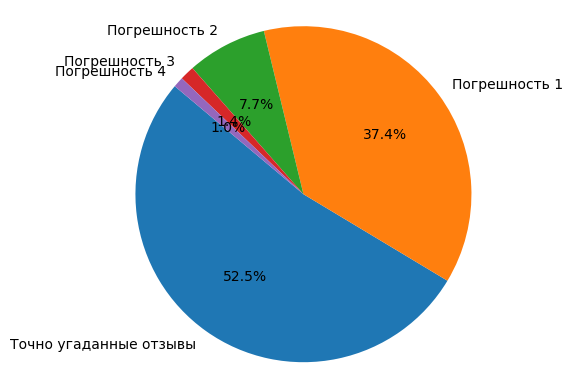

In [26]:
from matplotlib import pyplot as plt

sizes = [dups[0], dups[1], dups[4], dups[9], dups[16]]
labels = ['Точно угаданные отзывы', 'Погрешность 1', 'Погрешность 2', 'Погрешность 3', 'Погрешность 4']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140) 
plt.axis('equal')
plt.show() 

In [49]:
c = 0
for j in range(1,6):
    for i, row in test_df.iterrows():  
        if (row['label'] == row['prediction']) and (row['label'] == j):
            c += 1
    print(f'Количество истинных оценок {j}: 200\
        Количество верно угаданных оченок {j}: {c}')
    c = 0

Количество истинных оценок 1: 200        Количество верно угаданных оченок 1: 126
Количество истинных оценок 2: 200        Количество верно угаданных оченок 2: 64
Количество истинных оценок 3: 200        Количество верно угаданных оченок 3: 72
Количество истинных оценок 4: 200        Количество верно угаданных оченок 4: 108
Количество истинных оценок 5: 200        Количество верно угаданных оченок 5: 155
